# Libraries

In [48]:
#        DATA
# ==================== #
import pandas as pd
import numpy as np
from scipy import stats
import time
import random
import math

#      PLOTING
# ============================== #

from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="white")

#      TimeSeries
# ============================== #


#      CLUSTERING
# ============================== #
from sklearn.cluster import KMeans
from scipy.sparse import hstack

#      PRE PROCESSING
# ============================== #
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
#      METRICS
# ============================== #
from sklearn.metrics import f1_score   # average='micro'
from sklearn.model_selection import cross_val_score , StratifiedShuffleSplit , RepeatedStratifiedKFold

#      MODEL SELECTION
# ============================== #
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

#      CLASIFICATORS
# ============================== #
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC


#      OTHERS
# ============================== #
from sklearn.inspection import permutation_importance
import multiprocessing

from python.funcionesPropias import *

#      WARNINGS
# ============================== #
import warnings
warnings.filterwarnings("ignore")
import dill

# Data

In [56]:
df = pd.read_csv('./data/dfFinal.csv')
print(f"Tenemos {df.shape[1]} columnas y {df.shape[0]} filas")

Tenemos 18 columnas y 1860 filas


In [57]:
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df = df.set_index('fecha')
df = df.asfreq('D')
df = df.sort_index()
df.head()

,traffic_volume,dia,mes,ano,Día_semana,laborable,tipoFestivo,festividad,tmed,prec,tmin,tmax,dir,velmedia,racha,presMax,presMin
fecha,,,,,,,,,,,,,,,,,
2012-10-02,63289.0,2.0,10.0,2012.0,martes,laborable,NaN,NaN,16.733333,0.0,10.533333,22.966667,22.333333,1.2,6.200000,946.1,943.8
2012-10-03,66345.0,3.0,10.0,2012.0,miércoles,laborable,NaN,NaN,17.400000,0.0,11.500000,23.400000,22.000000,0.8,6.100000,944.3,941.2
2012-10-04,89939.0,4.0,10.0,2012.0,jueves,laborable,NaN,NaN,17.900000,0.0,12.000000,23.800000,3.000000,1.1,5.800000,941.7,937.7
2012-10-05,93336.0,5.0,10.0,2012.0,viernes,laborable,NaN,NaN,19.200000,0.0,13.500000,25.000000,7.000000,1.4,6.700000,943.2,940.6
2012-10-06,74910.0,6.0,10.0,2012.0,sábado,sábado,NaN,NaN,17.466667,0.0,11.500000,23.400000,21.666667,1.7,9.066667,945.4,941.4


In [58]:
df.loc[df['Día_semana'].isna(), 'Día_semana'] = 'lunes'

In [59]:
dias_semana = {
    'lunes' : 1,
    'martes' : 2,
    'miércoles' : 3,
    'jueves' : 4,
    'viernes' : 5,
    'sábado' : 6,
    'domingo' : 7
}
df['diaSemana'] = df['Día_semana'].apply(lambda x : dias_semana[x])
df.drop('Día_semana', axis= 1, inplace= True)

In [60]:
laborable = {
    'laborable' : 0,
    'sábado' : 1,
    'sabado' : 1,
    'domingo' : 2,
    'festivo' :3,
    np.nan : 0
}

df['laborable'] = df['laborable'].apply(lambda x : laborable[x])

In [61]:
tipoFestivo = {
    np.nan : 0,
    'Festivo local de la ciudad de Madrid' :1,
    'Festivo de la comunidad de Madrid' : 2,
    'Festivo de la Comunidad de Madrid' : 2,
    'Festivo nacional' :3,

}

df['tipoFestivo'] = df['tipoFestivo'].apply(lambda x : tipoFestivo[x])

In [62]:
df['festividad'].fillna('n', inplace= True)

In [63]:
# Verificar que un índice temporal está completo
# ==============================================================================
(df.index == pd.date_range(
                    start = df.index.min(),
                    end   = df.index.max(),
                    freq  = df.index.freq)
).all()

#https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html

True

# EDA

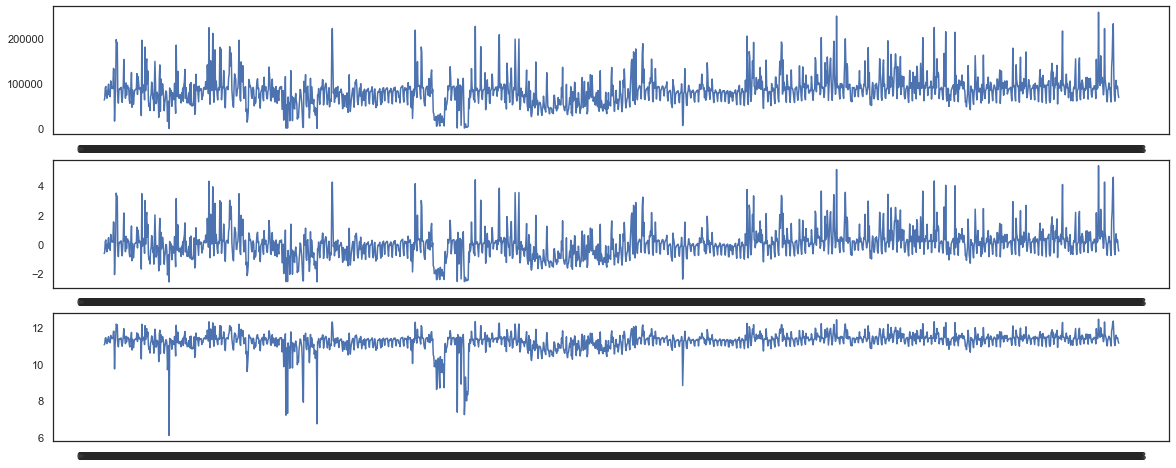

In [52]:
fig, ax1 = plt.subplots(1,1,figsize=(20,8))
ax1.plot(df.traffic_volume)
fig.show()

Voy a trabajar con un trozo, para ver mejor los gráficos

In [64]:
mean = df.traffic_volume.mean()
sd = df.traffic_volume.std()

In [82]:
dias = 365*2
datos_eda  = df[-dias:]
datos_numeric = datos_eda.select_dtypes(['int','float'])[['traffic_volume','tmed','prec','tmin','tmax','dir','velmedia','racha','presMax','presMin']]
datos_numeric.head()

,traffic_volume,tmed,prec,tmin,tmax,dir,velmedia,racha,presMax,presMin
fecha,,,,,,,,,,
2016-10-01,68254.0,20.333333,0.0,13.533333,27.133333,26.0,1.9,11.1,938.9,936.4
2016-10-02,59810.0,19.533333,0.0,12.533333,26.566667,24.0,1.4,8.1,941.3,937.8
2016-10-03,78844.0,20.433333,0.0,13.100000,27.766667,20.0,0.8,4.7,944.5,940.9
2016-10-04,83054.0,20.933333,0.0,14.100000,27.733333,22.0,1.1,5.0,945.3,941.4
2016-10-05,83459.0,20.833333,0.0,14.466667,27.133333,4.0,1.4,6.1,943.2,937.9


Vemos como hay datos en la presion que son NULL podemos imputarlos estimando estos valores para la serie en esos casos. Además, vemos como la mayoría de series son estarionarias, por lo que debemos tratarlo como tal. Vamos a ir comparando de 2 en 2 con la objetivo para ver si existe algún patron.

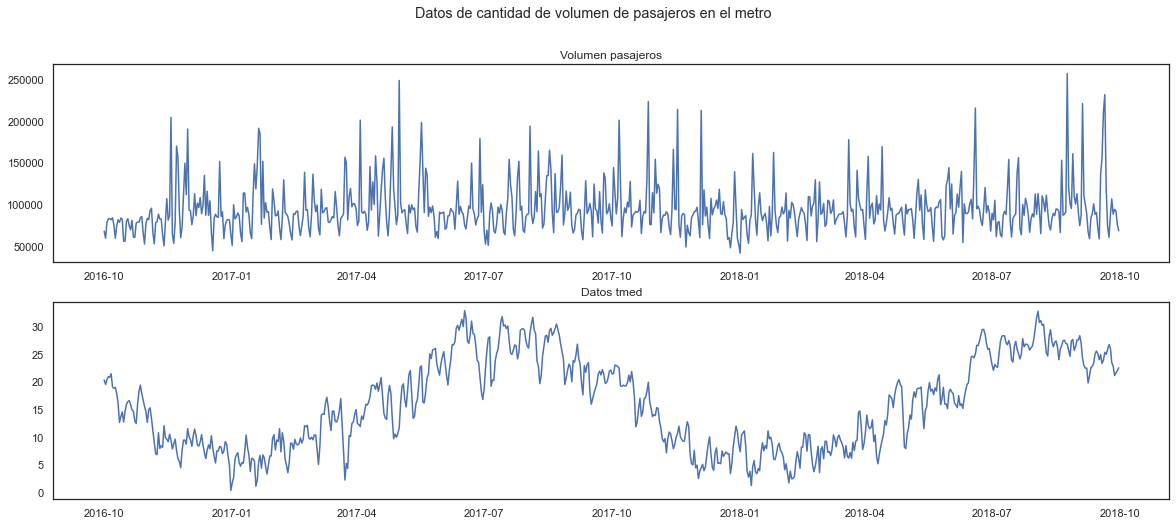

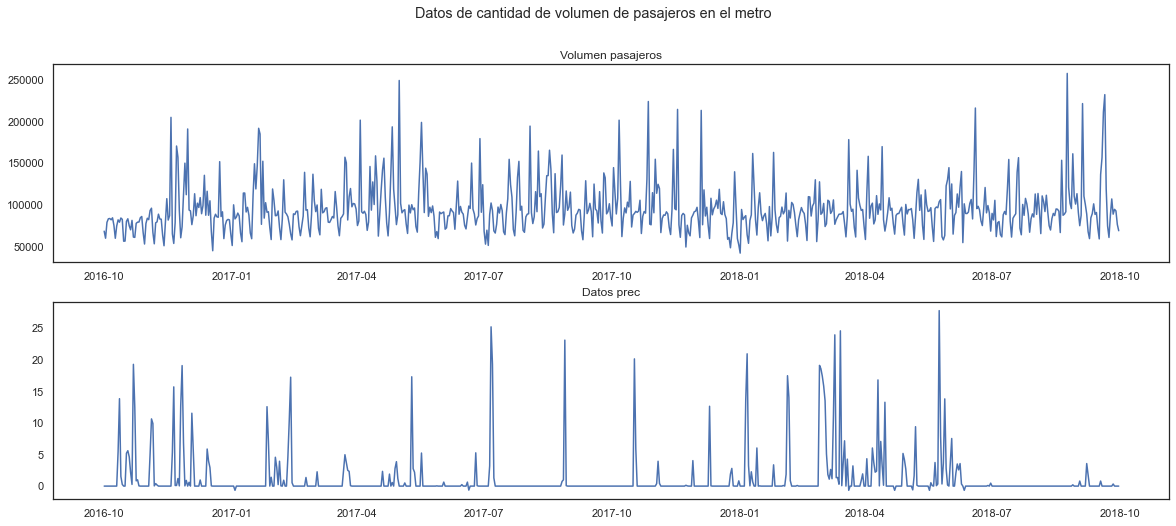

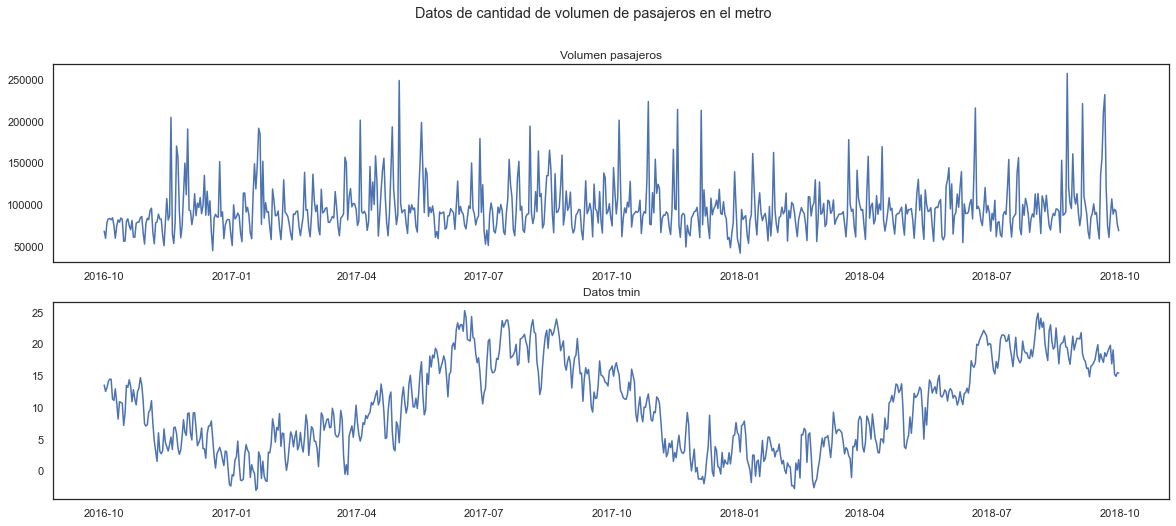

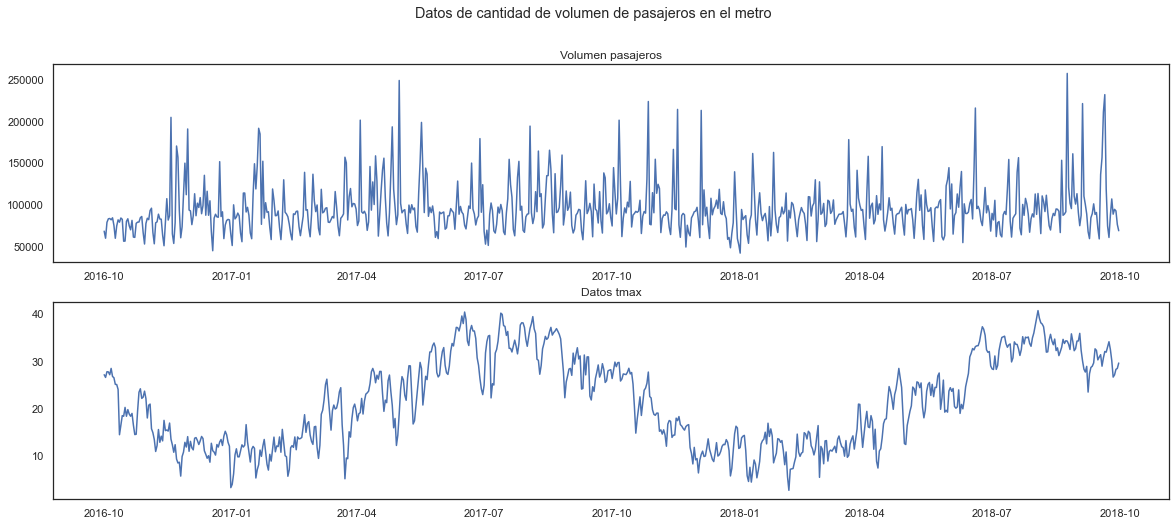

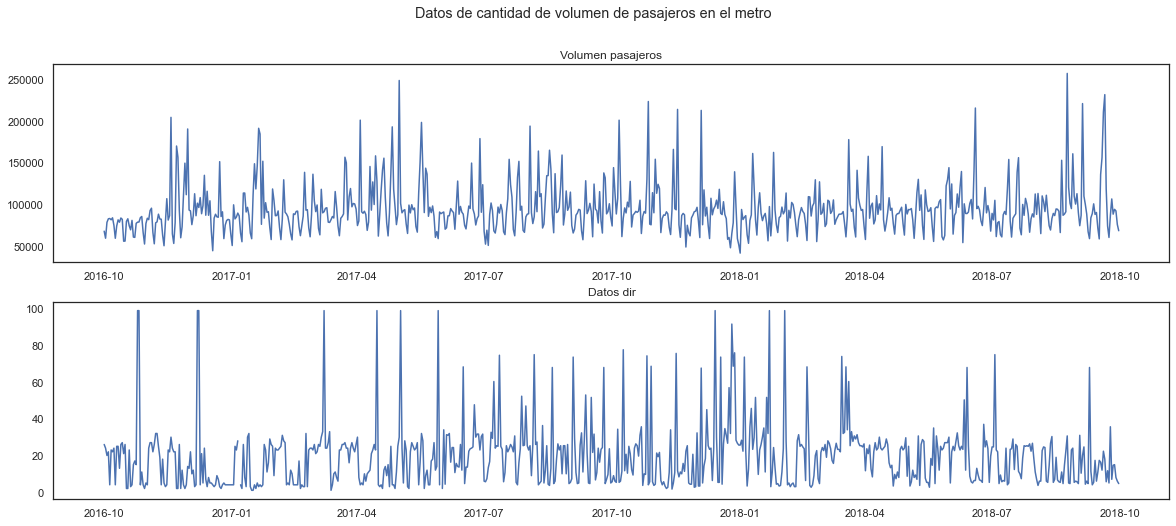

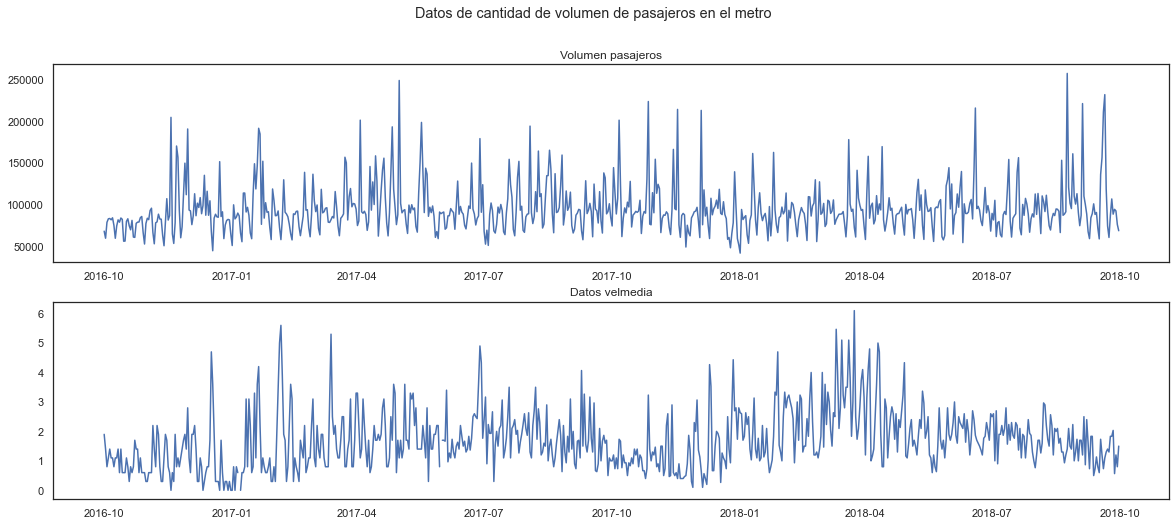

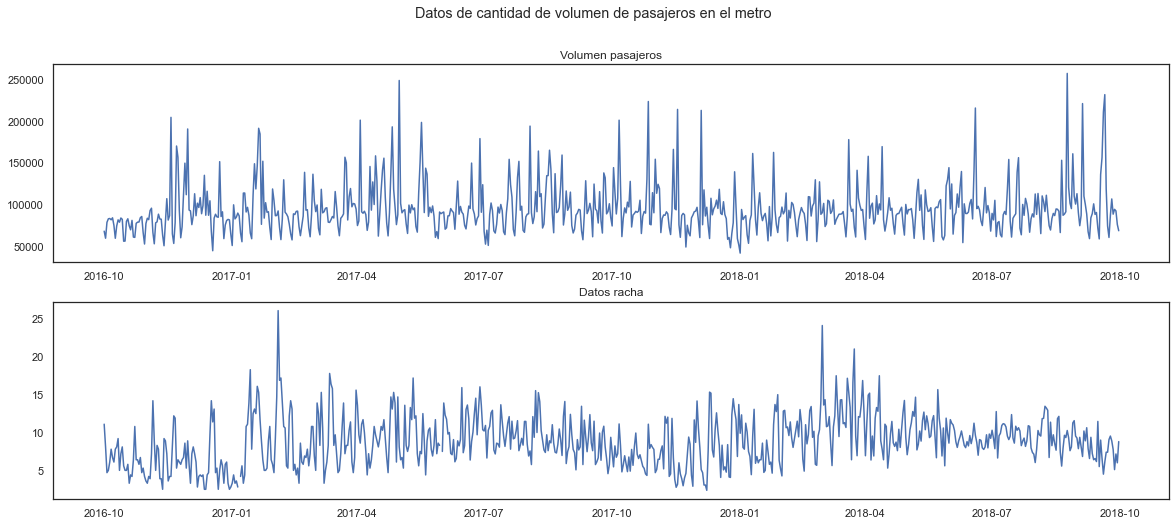

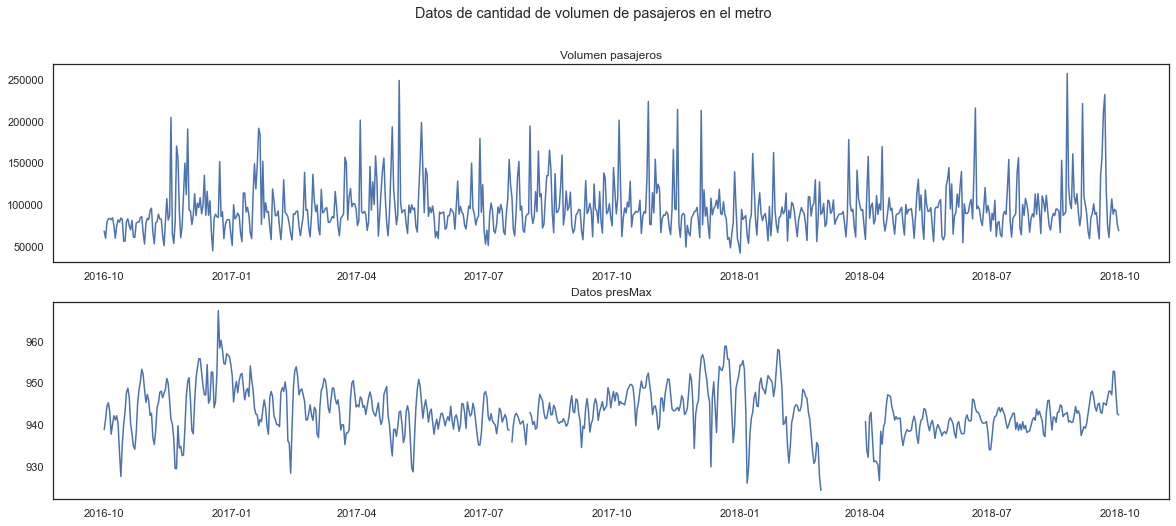

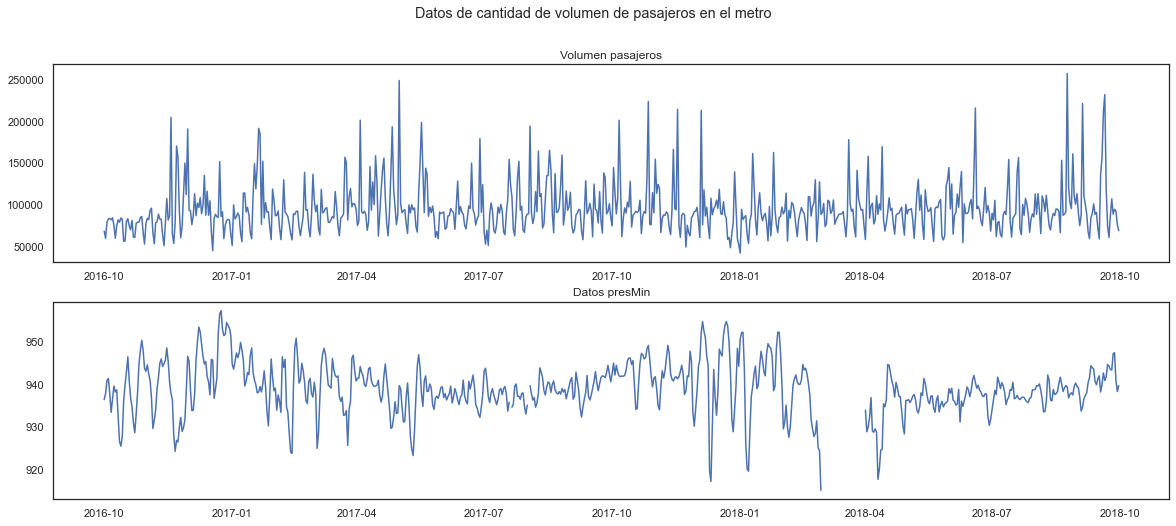

In [85]:
for col in ['tmed', 'prec', 'tmin', 'tmax', 'dir', 'velmedia','racha', 'presMax', 'presMin']:
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,8))
    fig.suptitle("Datos de cantidad de volumen de pasajeros en el metro")
    ax1.plot(datos_numeric.traffic_volume)
    ax1.set_title('Volumen pasajeros')
    ax2.plot(datos_numeric[col])
    ax2.set_title(f"Datos {col}")
    fig.show()

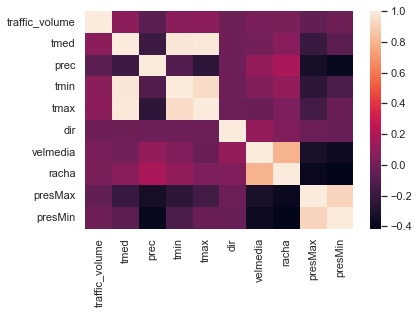

In [87]:
sns.heatmap(datos_numeric.corr())
plt.show()